# Dataset Installization & Pips

In [ ]:
pip install --upgrade ir_datasets

In [2]:
import ir_datasets
dataset = ir_datasets.load("antique/train")

In [ ]:
pip install inflect

In [ ]:
pip install --upgrade sentence-transformers

In [ ]:
!pip install langchain-community

In [ ]:
!pip install chromadb

# Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports


In [ ]:
import nltk
import pandas as pd
import math
import string
import re
import time
import gensim
import numpy as np

from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
stopwords.words('english')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


# Classes

In [ ]:
class GenericDoc:
  def __init__(self, doc_id, text):
    self.doc_id = doc_id
    self.text = text

  def __str__(self):
    return f"GenericDoc(doc_id:'{self.doc_id}', text:\" {self.text}\")"

  def key(self):
    return self.doc_id

  def value(self):
    return self.text

#Methods

## Word Norm

In [ ]:
import re

def remove_repeated_letters_with_regex(doc):
    return  re.sub(r'(.)\1+', r'\1', doc)

## Date

In [ ]:
from datetime import datetime

def norm_date(words):
    new_texts = []
    for word in words:
        try:
            date_obj = datetime.strptime(word, "%Y-%m-%d")
            formatted_date = date_obj.strftime("%Y %m %d")
            day_name = date_obj.strftime("%A")
            month_name = date_obj.strftime("%B")
            time_obj = date_obj.time().strftime("%I %M %p")
            new_formatted = f"{formatted_date} {day_name} {month_name} {time_obj}"
            new_texts.extend(new_formatted.split())
        except (ValueError, OverflowError):
            new_texts.append(word)
    return new_texts

## URLs

In [ ]:
def remove_urls(doc):
  return re.sub("http[^\s]*","",doc,flags = re.IGNORECASE)

## Spacing

In [ ]:
def spacing(text):
    text = re.sub(r'[_.-`,]', ' ', text)
    return text

## Expand Abbreviation

In [ ]:
res = []
def expand(words):
  for word in words:
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            res.extend(spacing(l.name()))
  res_set = set(res)
  if len(res_set) != 0:
   words=res_set
  return words

##Stop Words

In [ ]:
def remove_stop_words(doc_id,words):
  res=[]
  for word in words:
   if word not in stopwords.words('english'):
      res.append(word)
  return res

## Unknown Words

In [ ]:
def remove_unknown_words(words):
  res = []
  spell = SpellChecker()
  misspelled = spell.unknown(words)
  for word in words:
    if word not in misspelled:
      res.append(word)
  return res

##Stemming

In [ ]:

def stemming(words):
  stemming_words =[]
  stemmer = PorterStemmer()
  for word in words:
    temp = stemmer.stem(word)
    if len(temp) > 1:
      stemming_words.append(temp)
    else:
      if temp.isnumeric():
       stemming_words.append(temp)

  return stemming_words

## POS

In [ ]:
def get_wordnet_pos(tag_parameter):

    tag = tag_parameter[0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

##Lemmatization

In [ ]:
def lemmatization(words,pos_tags):

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  lemmatized_words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags]
  return lemmatized_words

## Extract Alphanumeric

In [ ]:
import re
def isAlphaNumeric(str):

    regex = "^(?=.*[a-zA-Z])(?=.*[0-9])[A-Za-z0-9]+$"
    p = re.compile(regex)

    if(str == None):
        return True

    if(re.search(p, str)):
        return True
    else:
        return False


## Regex

In [ ]:
def remove_special_characters(words): # Word Level
    res = []
    for word in words:
        cleaned_word = re.sub(r'[^A-Za-z0-9]+', '', word)
        res.append(cleaned_word)
    return res

In [ ]:
def ARSC(text): # Document Level
  return re.sub(r'[^A-Za-z0-9]+', ' ', text)

## Numbers To Words

In [ ]:
from dataclasses import replace
import inflect

def numberToWord(words):
    p = inflect.engine()
    res = []
    for word in words:
        try:
            if word.isnumeric():
                word = p.number_to_words(int(word), decimal=" ", andword=" ")
                word = re.sub(r' ','_',word)
                res.append(word)
            else:
                res.append(word)
        except Exception as e:
            pass
    return res


# Storing

In [4]:
import pickle

def save(vectorizer, path):
    with open(path, "wb") as f:
        pickle.dump(vectorizer, f)

def load(path):
    with open(path, "rb") as f:
        return pickle.load(f)

# Text Processing

In [ ]:
stop_words = set(stopwords.words('english'))
def process(document):

    doc_id, doc = document

    # Lower
    doc = doc.lower().strip()

    #ARSC
    doc = ARSC(doc)


    # Tokenize into words
    words = word_tokenize(doc)

    # POS
    pos = pos_tag(words)

    # Stop Words
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    words = lemmatization(words,pos)

    # Stemming
    words = stemming(words)

    # Number To Word
    words = numberToWord(words)


    return doc_id, ' '.join(words)


# Clean Data

## Train


In [ ]:
cleand_data= []
data_names= []
def clean(docs):
  temp_data = []
  temp_names = []
  for doc in docs:
    name, res = process(doc)
    temp_names.append(doc.doc_id)
    temp_data.append(res)
  data_names.extend(temp_names)
  cleand_data.extend(temp_data)

In [ ]:
clean(dataset.docs_iter()[:40366])

In [ ]:
clean(dataset.docs_iter()[40366:80732])

In [ ]:
clean(dataset.docs_iter()[80732:121098])

In [ ]:
clean(dataset.docs_iter()[121098:161464])

In [ ]:
clean(dataset.docs_iter()[161464:201830])

In [ ]:
clean(dataset.docs_iter()[201830:242196])

In [ ]:
clean(dataset.docs_iter()[242196:282562])

In [ ]:
len(cleand_data)

282562

In [ ]:
clean(dataset.docs_iter()[282562:322928])

In [ ]:
clean(dataset.docs_iter()[322928:363294])

In [ ]:
clean(dataset.docs_iter()[363294:403660])

In [ ]:
clean(dataset.docs_iter()[403660:403666])

In [ ]:
save(cleand_data, "/content/drive/My Drive/IR/antique/cleand_data.pkl")
save(data_names,"/content/drive/My Drive/IR/antique/data_names.pkl")

## Load Clean Data

In [ ]:
cleand_data = load("/content/drive/My Drive/IR/antique/cleand_data.pkl")
data_names = load("/content/drive/My Drive/IR/antique/data_names.pkl")

In [ ]:
doc_lengths =[]
for data in cleand_data:
  doc_lengths.append(len(data))
len(doc_lengths)

403666

# Qrels

In [ ]:
qrels = []
for q in dataset.qrels_iter():
  qrels.append(q)

# Vectorizer, TFIDF Matrix


## ReCalculate Values

In [ ]:
# Vectorizer
vectorizer = TfidfVectorizer()

# TFIDF Matrix
tfidf_matrix = vectorizer.fit_transform(cleand_data)

# Saving
save(vectorizer, "/content/drive/My Drive/IR/antique/vectorizer.pkl")
save(tfidf_matrix, "/content/drive/My Drive/IR/antique/tfidf_matrix.pkl")


## Load Calculated Values

In [ ]:
# Loading
vectorizer = load("/content/drive/My Drive/IR/antique/vectorizer.pkl")
tfidf_matrix = load("/content/drive/My Drive/IR/antique/tfidf_matrix.pkl")

## Matching

### Basic Match

In [ ]:

def match_query(query):
    query_tfidf = vectorizer.transform([query])
    query_vector = query_tfidf.toarray()[0]
    similarity = cosine_similarity(query_vector.reshape(1, -1), tfidf_matrix).flatten()
    sorted_indices = np.argsort(similarity)[::-1]
    sorted_documents = [(data_names[i]) for i in sorted_indices if similarity[i] > 0]
    return sorted_documents

### Match with Length Normaliztion

In [ ]:
import numpy as np

pivot = np.mean(np.sum(tfidf_matrix, axis=1))


slope = 0.75

normalized_matrix = tfidf_matrix / ((1 - slope) * pivot + slope * np.sum(tfidf_matrix, axis=1))

def match_query_length_normalization(query):
    query_tfidf = vectorizer.transform([query])
    query_vector = query_tfidf.toarray()[0]
    similarity = cosine_similarity(query_vector.reshape(1, -1), normalized_matrix).flatten()
    sorted_indices = np.argsort(similarity)[::-1]
    sorted_documents = [(data_names[i]) for i in sorted_indices[:10] if similarity[i] > 0]
    return sorted_documents

## Query Results

### Calculate & Save

In [ ]:
query_results = {}

for query in dataset.queries_iter():
    query_name, cleaned_query = process(query)
    result_value = match_query(cleaned_query)
    query_results[query_name] = result_value

save(query_results, "/content/drive/My Drive/IR/antique/query_results.pkl")

### Load

In [6]:
query_results = load("/content/drive/My Drive/IR/antique/query_results.pkl")

# Evaluation Methods


In [7]:
def calculate_relevant_count( retrieved_docs, query_docs):
    intersect_values = np.intersect1d(retrieved_docs, query_docs)
    matched_count = len(intersect_values)
    return matched_count

In [8]:
def getDocsByQid(qrels, queryId):
    relevant_docs = []
    flag: bool = False
    for qid, doc_id, relevance, iteration in qrels:
        if qid == queryId:
            flag = True
            relevant_docs.append(doc_id)
        elif flag:
            break;
        else:
            continue
    return relevant_docs

In [9]:
def average_precision(retrieved_docs, relevant_docs, k=10):
    total_precisions = 0
    curr_relavant = 1
    if len(relevant_docs) == 0:
        return 0
    if len(retrieved_docs) <= k:
        k = len(retrieved_docs)
    for i in range(k):
        if retrieved_docs[i] in relevant_docs:
            total_precisions += curr_relavant / (i + 1)
            curr_relavant += 1
    matched = calculate_relevant_count(retrieved_docs[:k], relevant_docs)

    if matched == 0:
        return 0
    return total_precisions / matched

In [10]:

def calculate_map( queries, qrles):
    total_ap = 0
    for query_id, docs in queries.items():
      retrieved_docs= queries.get(query_id)[:10]
      relevant_docs=getDocsByQid(qrels,query_id)
      avg= average_precision(retrieved_docs, relevant_docs)
      total_ap += avg

    map_score = total_ap / len(queries)
    return map_score

In [11]:
def get_first_matched_position(qrles, queries):
    for query_id in queries:
        docs_list = queries[query_id]
        queries[query_id] = docs_list[:10]
    matched_positions = {}
    for query_id in queries:
        matched_positions[query_id] = -1
        for i, doc in enumerate(queries[query_id]):
            if doc in getDocsByQid(qrles,query_id):
                matched_positions[query_id] = i
                break
    return matched_positions

In [12]:
def mean_reciprocal_rank(qrels, queries):
    matched_positions = get_first_matched_position(qrels, queries)
    total_rr = 0
    for query_id, matched_position in matched_positions.items():
        if matched_position == -1:
            total_rr += 0
            continue
        total_rr += (1 / (int(matched_position) + 1))
    mrr = (total_rr) * (1 / len(qrels))
    return mrr

In [13]:
def precisionAtTen(query_id, queries):
    retrieved_docs= queries.get(query_id)[:10]
    relevant_docs=getDocsByQid(qrels,query_id)
    number_of_relevant_docs = calculate_relevant_count(retrieved_docs, relevant_docs)
    precision = number_of_relevant_docs / 10
    return precision

In [14]:
def recall(query_id, queries, k = 0):
  if(k==0):
    retrieved_docs= queries.get(query_id)
  else:
    retrieved_docs= queries.get(query_id)[:k]

  relevant_docs=getDocsByQid(qrels,query_id)
  number_of_relevant_docs = calculate_relevant_count(retrieved_docs, relevant_docs)
  recall_value = number_of_relevant_docs / len(relevant_docs)
  return recall_value

# Word Embeding

## Word2Vec

In [ ]:
import numpy as np

def get_embedding_vector(model, doc_tokens, size=100):
    if not doc_tokens:
        return np.zeros(size)

    embeddings = []
    for tok in doc_tokens:
        if tok in model.wv:
            embeddings.append(model.wv[tok])
        else:
            embeddings.append(np.zeros(size))

    if embeddings:
        embeddings = np.asarray(embeddings)
        vector = np.mean(embeddings, axis=0)
    else:
        return np.zeros(size)

    return vector


### Train

In [ ]:
from nltk.tokenize import word_tokenize
import numpy as np

tokenized_documents = [word_tokenize(doc) for doc in cleand_data if isinstance(doc, str)]


In [ ]:
from gensim.models import Word2Vec

vector_size = 100
epochs = 30
workers = 2


print('training word2vec')
model = Word2Vec(tokenized_documents, vector_size=vector_size, sg=1, workers=workers, epochs=epochs)

print('storing word2vec model')
model.save("/content/drive/My Drive/IR/antique/wbModel.pkl")

print('calculating document vectors')
document_vectors = [get_embedding_vector(model, doc_tokens) for doc_tokens in tokenized_documents]

print('storing documents vectors')
save(document_vectors, "/content/drive/My Drive/IR/antique/document_vectors.pkl")
print('training model has ended')

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec.load("/content/drive/My Drive/IR/antique/wbModel.pkl")
document_vectors = load("/content/drive/My Drive/IR/antique/document_vectors.pkl")

### Matching

In [ ]:
def WEmatchingAndRanking(query):
    retrived = []

    query_tokens = word_tokenize(query)

    query_vector = get_embedding_vector(model, query_tokens)

    similarity_scores =  cosine_similarity([query_vector], document_vectors)[0]

    sorted_docs = np.argsort(similarity_scores)[::-1]

    retrived = [(data_names[i]) for i in sorted_docs[:10]]
    return retrived

### Query Results

In [ ]:
WE_query_results = {}
i = 0;
for query in dataset.queries_iter():
    i+=1
    print(i)
    query_name, cleaned_query = process(query)
    result_value = WEmatchingAndRanking(cleaned_query)
    WE_query_results[query_name] = result_value

save(WE_query_results, "/content/drive/My Drive/IR/antique/WE_query_results.pkl")

### W2V Map

In [ ]:
Map = calculate_map(WE_query_results, qrels)
Map

0.27285007272198397

## Hugging Face Embedding

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
model = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1"
embeddings = HuggingFaceEmbeddings(
    model_name=model,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
    show_progress="false"
)

In [ ]:
embeddings_list = []

In [ ]:
embeddings_list.extend(embeddings.embed_documents(cleand_data))

In [ ]:
save(embeddings_list, "/content/drive/My Drive/IR/antique/embeddings_list.pkl")

### Load

In [ ]:
embeddings_list = load("/content/drive/My Drive/IR/antique/embeddings_list.pkl")

### Matching

In [ ]:
def HFmatchingAndRanking(query):
    retrived = []

    query_vector =  embeddings.embed_query(query)

    similarity_scores =  cosine_similarity([query_vector], embeddings_list)[0]

    sorted_docs = np.argsort(similarity_scores)[::-1]

    retrived = [(data_names[i]) for i in sorted_docs if similarity_scores[i] > 0 ]

    return retrived

### Queries Result

In [ ]:
HF_query_results = {}
i = 0;
for query in dataset.queries_iter():
    i+=1
    print(i)
    query_name, cleaned_query = process(query)
    result_value = HFmatchingAndRanking(cleaned_query)
    HF_query_results[query_name] = result_value

# save(HF_query_results, "/content/drive/My Drive/IR/antique/HF_query_results.pkl")

In [ ]:
Map = calculate_map(HF_query_results, qrels)
Map

# Vector Store

## Chroma

In [ ]:
import chromadb
chroma_client = chromadb.Client()

In [ ]:
# chroma_client.delete_collection(name="Antique")
collection = chroma_client.create_collection(name="Antique")

In [ ]:
batch_size = 1000
num_documents = len(cleand_data)


for i in range(0, num_documents, batch_size):
    batch_data = cleand_data[i : i + batch_size]
    batch_names = data_names[i : i + batch_size]
    batch_embeddings = embeddings_list[i : i + batch_size]
    print(i)
    # Add the batch to the collection
    collection.add(
        documents=batch_data,
        ids=batch_names,
        embeddings=batch_embeddings
    )

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


## Matching & Ranking

In [ ]:
def matchingAndRanking(query):
  query_embedding_list = embeddings.embed_query(query)
  results = collection.query(
      query_embeddings=query_embedding_list,
      n_results=490,
  )
  return results["ids"][0]

## Queries Results

In [ ]:
lang_query_results = {}
i=0
for query_name, query in dataset.queries_iter():
    i+=1
    print(i)
    result_value = matchingAndRanking(query)
    lang_query_results[query_name] = result_value

save(lang_query_results, "/content/drive/My Drive/IR/antique/lang_query_results.pkl")

## Load Queries Results

In [14]:
lang_query_results = load("/content/drive/My Drive/IR/antique/lang_query_results.pkl")

# Metrics Without Word embedding

## Recall

In [ ]:
queries_recall = []

for id, query in dataset.queries_iter():
  queries_recall.append(recall(id, query_results))


[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-train-queries.txt
[INFO] [finished] https://ciir.cs.umass.edu/downloads/Antique/antique-train-queries.txt: [00:00] [137kB] [675kB/s]


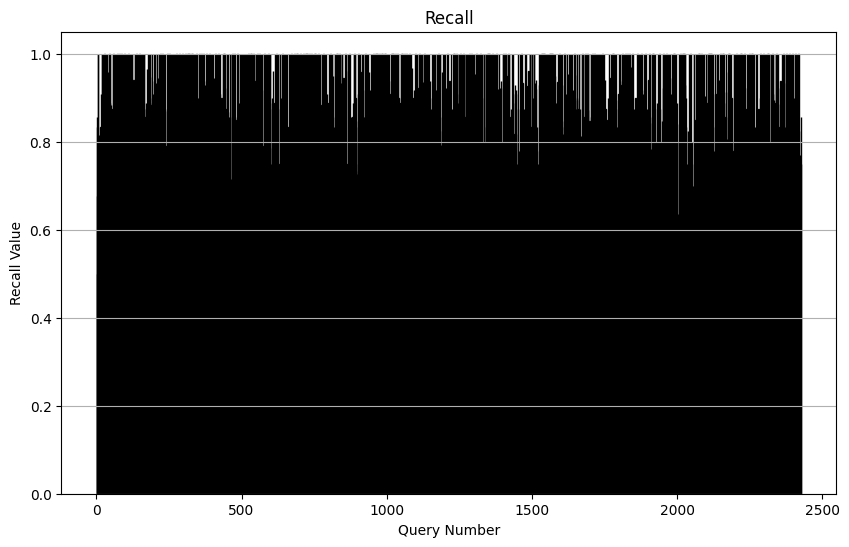

In [ ]:
import matplotlib.pyplot as plt
queries = range(1, len(queries_recall)+1)

plt.figure(figsize=(10, 6))
plt.bar(queries, queries_recall, color='skyblue', edgecolor='black')
plt.xlabel('Query Number')
plt.ylabel('Recall Value')
plt.title('Recall')
plt.grid(axis='y')
plt.show()

## Precision@10

In [ ]:
queries_PrecisionTen= []
for id, query in dataset.queries_iter():
  queries_PrecisionTen.append(precisionAtTen(id, query_results))

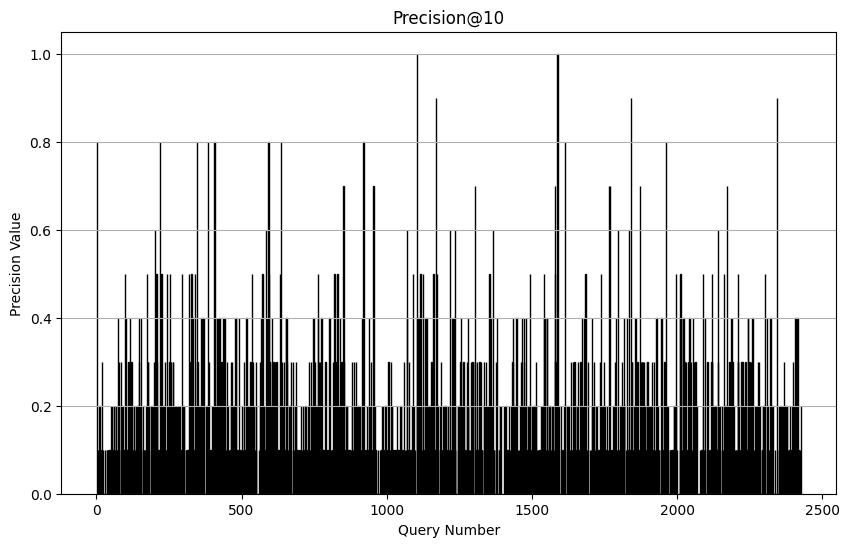

In [ ]:
import matplotlib.pyplot as plt
queries = range(1, len(queries_PrecisionTen)+1)

plt.figure(figsize=(10, 6))
plt.bar(queries, queries_PrecisionTen, color='skyblue', edgecolor='black')
plt.xlabel('Query Number')
plt.ylabel('Precision Value')
plt.title('Precision@10')
plt.grid(axis='y')
plt.show()

## MAP

In [15]:
Map = calculate_map(query_results, qrels)
Map

0.265600348158866

## MRR

In [ ]:
MRR = mean_reciprocal_rank(qrels, query_results)
MRR

0.025653339399601544

# Metrics With Word embedding

## Recall

In [ ]:
queries_recall = []

for id, query in dataset.queries_iter():
  queries_recall.append(recall(id, lang_query_results))


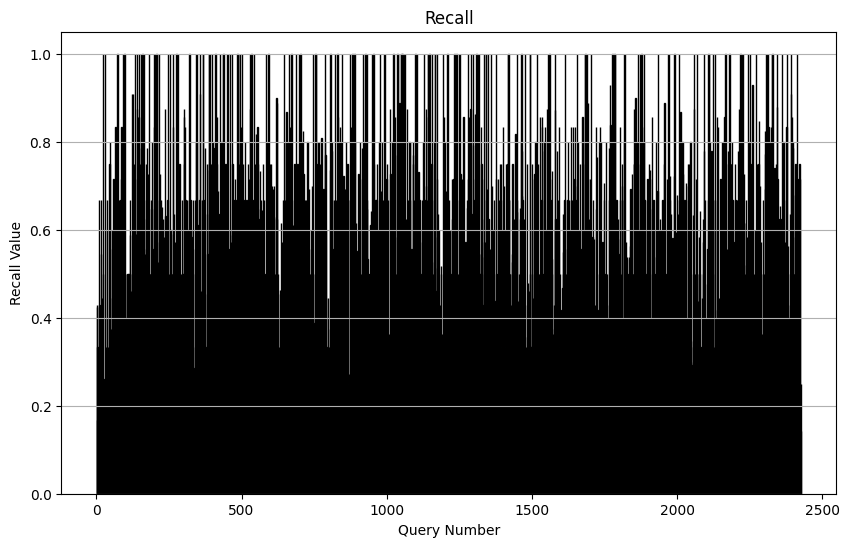

In [ ]:
import matplotlib.pyplot as plt
queries = range(1, len(queries_recall) + 1)

plt.figure(figsize=(10, 6))
plt.bar(queries, queries_recall, color='skyblue', edgecolor='black')
plt.xlabel('Query Number')
plt.ylabel('Recall Value')
plt.title('Recall')
plt.grid(axis='y')
plt.show()

## Precision@10

In [ ]:
queries_PrecisionTen= []
for id, query in dataset.queries_iter():
  queries_PrecisionTen.append(precisionAtTen(id, lang_query_results))

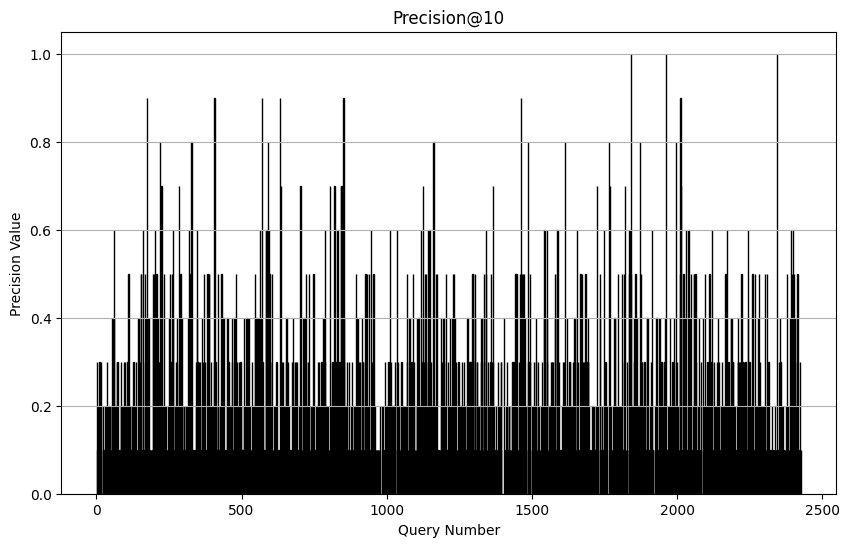

In [ ]:
import matplotlib.pyplot as plt
queries = range(1, 2427)

plt.figure(figsize=(10, 6))
plt.bar(queries, queries_PrecisionTen, color='skyblue', edgecolor='black')
plt.xlabel('Query Number')
plt.ylabel('Precision Value')
plt.title('Precision@10')
plt.grid(axis='y')
plt.show()

## Map

In [15]:
Map = calculate_map(lang_query_results, qrels)
Map

0.35497986566386225

## MRR

In [16]:
MRR = mean_reciprocal_rank(qrels, lang_query_results)
MRR

0.034568351445311625